# Verify models for visual proprioception

Verifies a regression model for visual proprioception, as trained in the notebook Train_VisualProprioception

The encoding and the regressor is specified in an experiment of type visual_proprioception. 

In [1]:
import sys
sys.path.append("..")
from exp_run_config import Config
Config.PROJECTNAME = "BerryPicker"

import pathlib
from pprint import pprint
import matplotlib.pyplot as plt
# fixing the fact that it defaults to Type 3 fonts
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

import numpy as np
import torch
import torch.nn as nn
#import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

torch.manual_seed(1)

from sensorprocessing import sp_conv_vae, sp_propriotuned_cnn
# from robot.al5d_position_controller import RobotPosition

from visual_proprioception.visproprio_helper import load_demonstrations_as_proprioception_training
from visual_proprioception.visproprio_models import VisProprio_SimpleMLPRegression
import sensorprocessing.sp_factory as sp_factory


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

/opt/homebrew/Cellar/python@3.13/3.13.5/Frameworks/Python.framework/Versions/3.13/lib/python3.13/pathlib/__init__.py
***ExpRun**: Loading pointer config file:
	/Users/lboloni/.config/BerryPicker/mainsettings.yaml
***ExpRun**: Loading machine-specific config file:
	/Users/lboloni/Google Drive/My Drive/LotziStudy/Code/PackageTracking/BerryPicker/settings/settings-szenes.yaml
Using device: cpu


In [2]:
experiment = "visual_proprioception"

# the latent space 128 ones
# run = "vp_aruco_128"
run = "vp_convvae_128"
# run = "vp_ptun_vgg19_128"
# run = "vp_ptun_resnet50_128"

# the latent space 256 ones
# run = "vp_convvae_256"
# run = "vp_ptun_vgg19_256"
# run = "vp_ptun_resnet50_256"
exp = Config().get_experiment(experiment, run)
pprint(exp)

exp_robot = Config().get_experiment(exp["robot_exp"], exp["robot_run"])

# Create the sp object described in the experiment
spexp = Config().get_experiment(exp["sp_experiment"], exp["sp_run"])
sp = sp_factory.create_sp(spexp, device)




***ExpRun**: Configuration for exp/run: visual_proprioception/vp_convvae_128 successfully loaded
Experiment:
    batch_size: 64
    data_dir: /Users/lboloni/Documents/Develop/Data/BerryPicker/visual_proprioception/vp_convvae_128
    encoding_size: 128
    epochs: 1000
    exp_run_sys_indep_file: /Users/lboloni/Documents/Develop/Github/BerryPicker/BerryPicker/src/experiment_configs/visual_proprioception/vp_convvae_128.yaml
    experiment_name: visual_proprioception
    loss: MSE
    name: conv-vae-128
    output_size: 6
    proprioception_input_file: train_inputs.pt
    proprioception_mlp_model_file: proprioception_mlp.pth
    proprioception_target_file: train_targets.pt
    proprioception_test_input_file: test_inputs.pt
    proprioception_test_target_file: test_targets.pt
    regressor_hidden_size_1: 64
    regressor_hidden_size_2: 64
    robot_exp: robot_al5d
    robot_run: position_controller_00
    run_name: vp_convvae_128
    sensor_processing: ConvVaeSensorProcessing
    sp_experi

In [3]:
# Create the regression model and load in the previously saved weights

model = VisProprio_SimpleMLPRegression(exp)
modelfile = pathlib.Path(exp["data_dir"], 
                         exp["proprioception_mlp_model_file"])
model.load_state_dict(torch.load(modelfile))
model.to(device)

VisProprio_SimpleMLPRegression(
  (model): Sequential(
    (0): Linear(in_features=128, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=6, bias=True)
  )
)

## Accuracy in time multigraph
Visualize the accuracy of the proprioception on the testing task, by plotting the ground truth. 

In [4]:

proprioception_input_file = pathlib.Path(
    exp["data_dir"], exp["proprioception_test_input_file"])
proprioception_target_file = pathlib.Path(
    exp["data_dir"], exp["proprioception_test_target_file"])

tr = load_demonstrations_as_proprioception_training(
    sp, exp, spexp, exp_robot, "validation_data", proprioception_input_file, proprioception_target_file, device=device
)

inputs = tr["inputs"] # these are actually tensors
targets = tr["targets"]
print(f"There are {inputs.shape[0]} data points")

***load_demonstrations_as_proprioception_training*** 
	Successfully loaded from cached files /Users/lboloni/Documents/Develop/Data/BerryPicker/visual_proprioception/vp_convvae_128/test_inputs.pt etc
There are 931 data points


In [5]:
no_from = 0
no_to = inputs.shape[0]
ypred = []
y = []
t = []
with torch.no_grad():
    for i in range(no_from, no_to):
        x = inputs[i]
        x = x.to(device)
        predictions = model(torch.unsqueeze(x, dim=0))
        # append the data 
        t.append(i)
        y.append(targets[i].numpy())
        ypred.append(predictions[0].cpu().numpy())

In [6]:
ypred = np.array(ypred)
y = np.array(y)
t = np.array(t)

Create a graph with the six degrees of freedom, predicted and real value

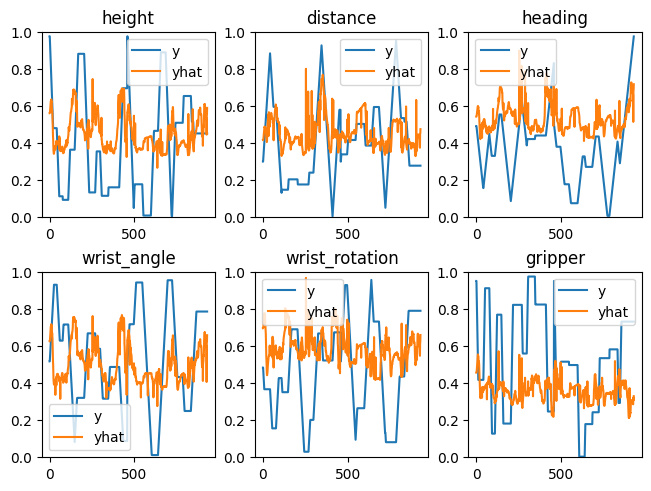

In [9]:
fig, axs = plt.subplots(2,3, constrained_layout=True)
titles = ["height","distance", "heading", "wrist_angle", "wrist_rotation", "gripper"]
#for i in range(Config()["robot"]["action_space_size"]):
for i in range(6):
    ax = axs[i//3, i%3] 
    ax.set_ylim(0, 1)
    ax.plot(t, y[:,i], label="y")
    ax.plot(t, ypred[:,i], label="yhat")
    ax.legend()
    ax.set_title(titles[i])

graphfilename = pathlib.Path(exp["data_dir"], "proprio_error.pdf")
plt.savefig(graphfilename)

In [ ]:
POS_MAX = {"height": 5.0, "distance": 10.0, "heading": 90.0, 
               "wrist_angle": 90.0, "wrist_rotation": 75.0 + 90.0, 
               "gripper": 100}

In [ ]:
for i, fld in enumerate(POS_MAX):
    print(i, fld)